In [1]:
from xai.mnist import MNIST
from xai.explainer import PermutationExplainer
import matplotlib.pyplot as plt
import torch
import random
import shap
import numpy as np

In [2]:
latent_dim = 5
device = "cpu"

mnist = MNIST((latent_dim,), device="cpu")
mnist

Sequential(
  (0): Linear(in_features=784, out_features=524, bias=True)
  (1): ReLU()
  (2): Linear(in_features=524, out_features=264, bias=True)
  (3): ReLU()
  (4): Linear(in_features=264, out_features=5, bias=True)
  (5): Linear(in_features=5, out_features=6, bias=True)
  (6): ReLU()
  (7): Linear(in_features=6, out_features=8, bias=True)
  (8): ReLU()
  (9): Linear(in_features=8, out_features=10, bias=True)
  (10): Softmax(dim=None)
)

In [3]:
stats = mnist.fit_autoencoder(
    epochs=1500,
    batch_size=128,
    loss_criterion="MSELoss",
    verbose=True,
    info="Autoencoder test"
)
stats[5:].plot_loss()

Loss: 0.026075: 100%|██████████| 1500/1500 [00:23<00:00, 64.24it/s]


In [4]:
stats = mnist.fit_classifier(
    epochs=1500,
    batch_size=256,
    loss_criterion="CrossEntropyLoss",
    verbose=True,
    info="Classifier test"
)
stats[5:].plot_loss()

Step::   0%|          | 0/1500 [00:00<?, ?it/s]/home/eivind/master-project/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

Loss: 1.652421: 100%|██████████| 1500/1500 [00:05<00:00, 252.00it/s]


In [ ]:
sample = mnist.val_data[900].numpy(force=True)
predict = mnist(sample)
recon = predict.reconstruction().numpy(force=True)
digit = predict.digits()[0]

recon_xai = predict.reconstruction_explanation(PermutationExplainer, verbose=True)[0].values
cls_xai = predict.classification_explanation(PermutationExplainer, verbose=True)[0].values

In [ ]:
recon_xai.shape, cls_xai.shape

In [ ]:
cls_xai.tolist()

In [ ]:
fig = plt.figure(figsize=(20,6)) 

sample = mnist.val_data[350].numpy(force=True)
predict = mnist(sample)
recon = predict.reconstruction().numpy(force=True)
digit = predict.digits()[0]

recon_xai = predict.reconstruction_explanation(PermutationExplainer, verbose=True)[0].values
cls_xai = predict.classification_explanation(PermutationExplainer, verbose=True)[0].values


fig.add_subplot(3,12,1)
plt.imshow(sample, cmap="gray")
    
fig.add_subplot(3,12,2)
plt.imshow(recon, cmap="gray")
    
for i in range(10):
    shap = np.zeros_like(recon_xai)
    fig.add_subplot(3,12,i+3)

    for j in range(latent_dim):
        shap[j] = recon_xai[j] * cls_xai[j,i]

    shap = shap.sum(axis=0)

    
    im = np.zeros((28,28,3), dtype=np.float32)
    norm = np.max(np.abs(shap))
    red = np.where(shap > 0, shap/norm, np.zeros_like(shap))
    blue = np.where(shap < 0, -shap/norm, np.zeros_like(shap))
    im[:,:,0] = red
    im[:,:,2] = blue
    plt.imshow(im)

digit

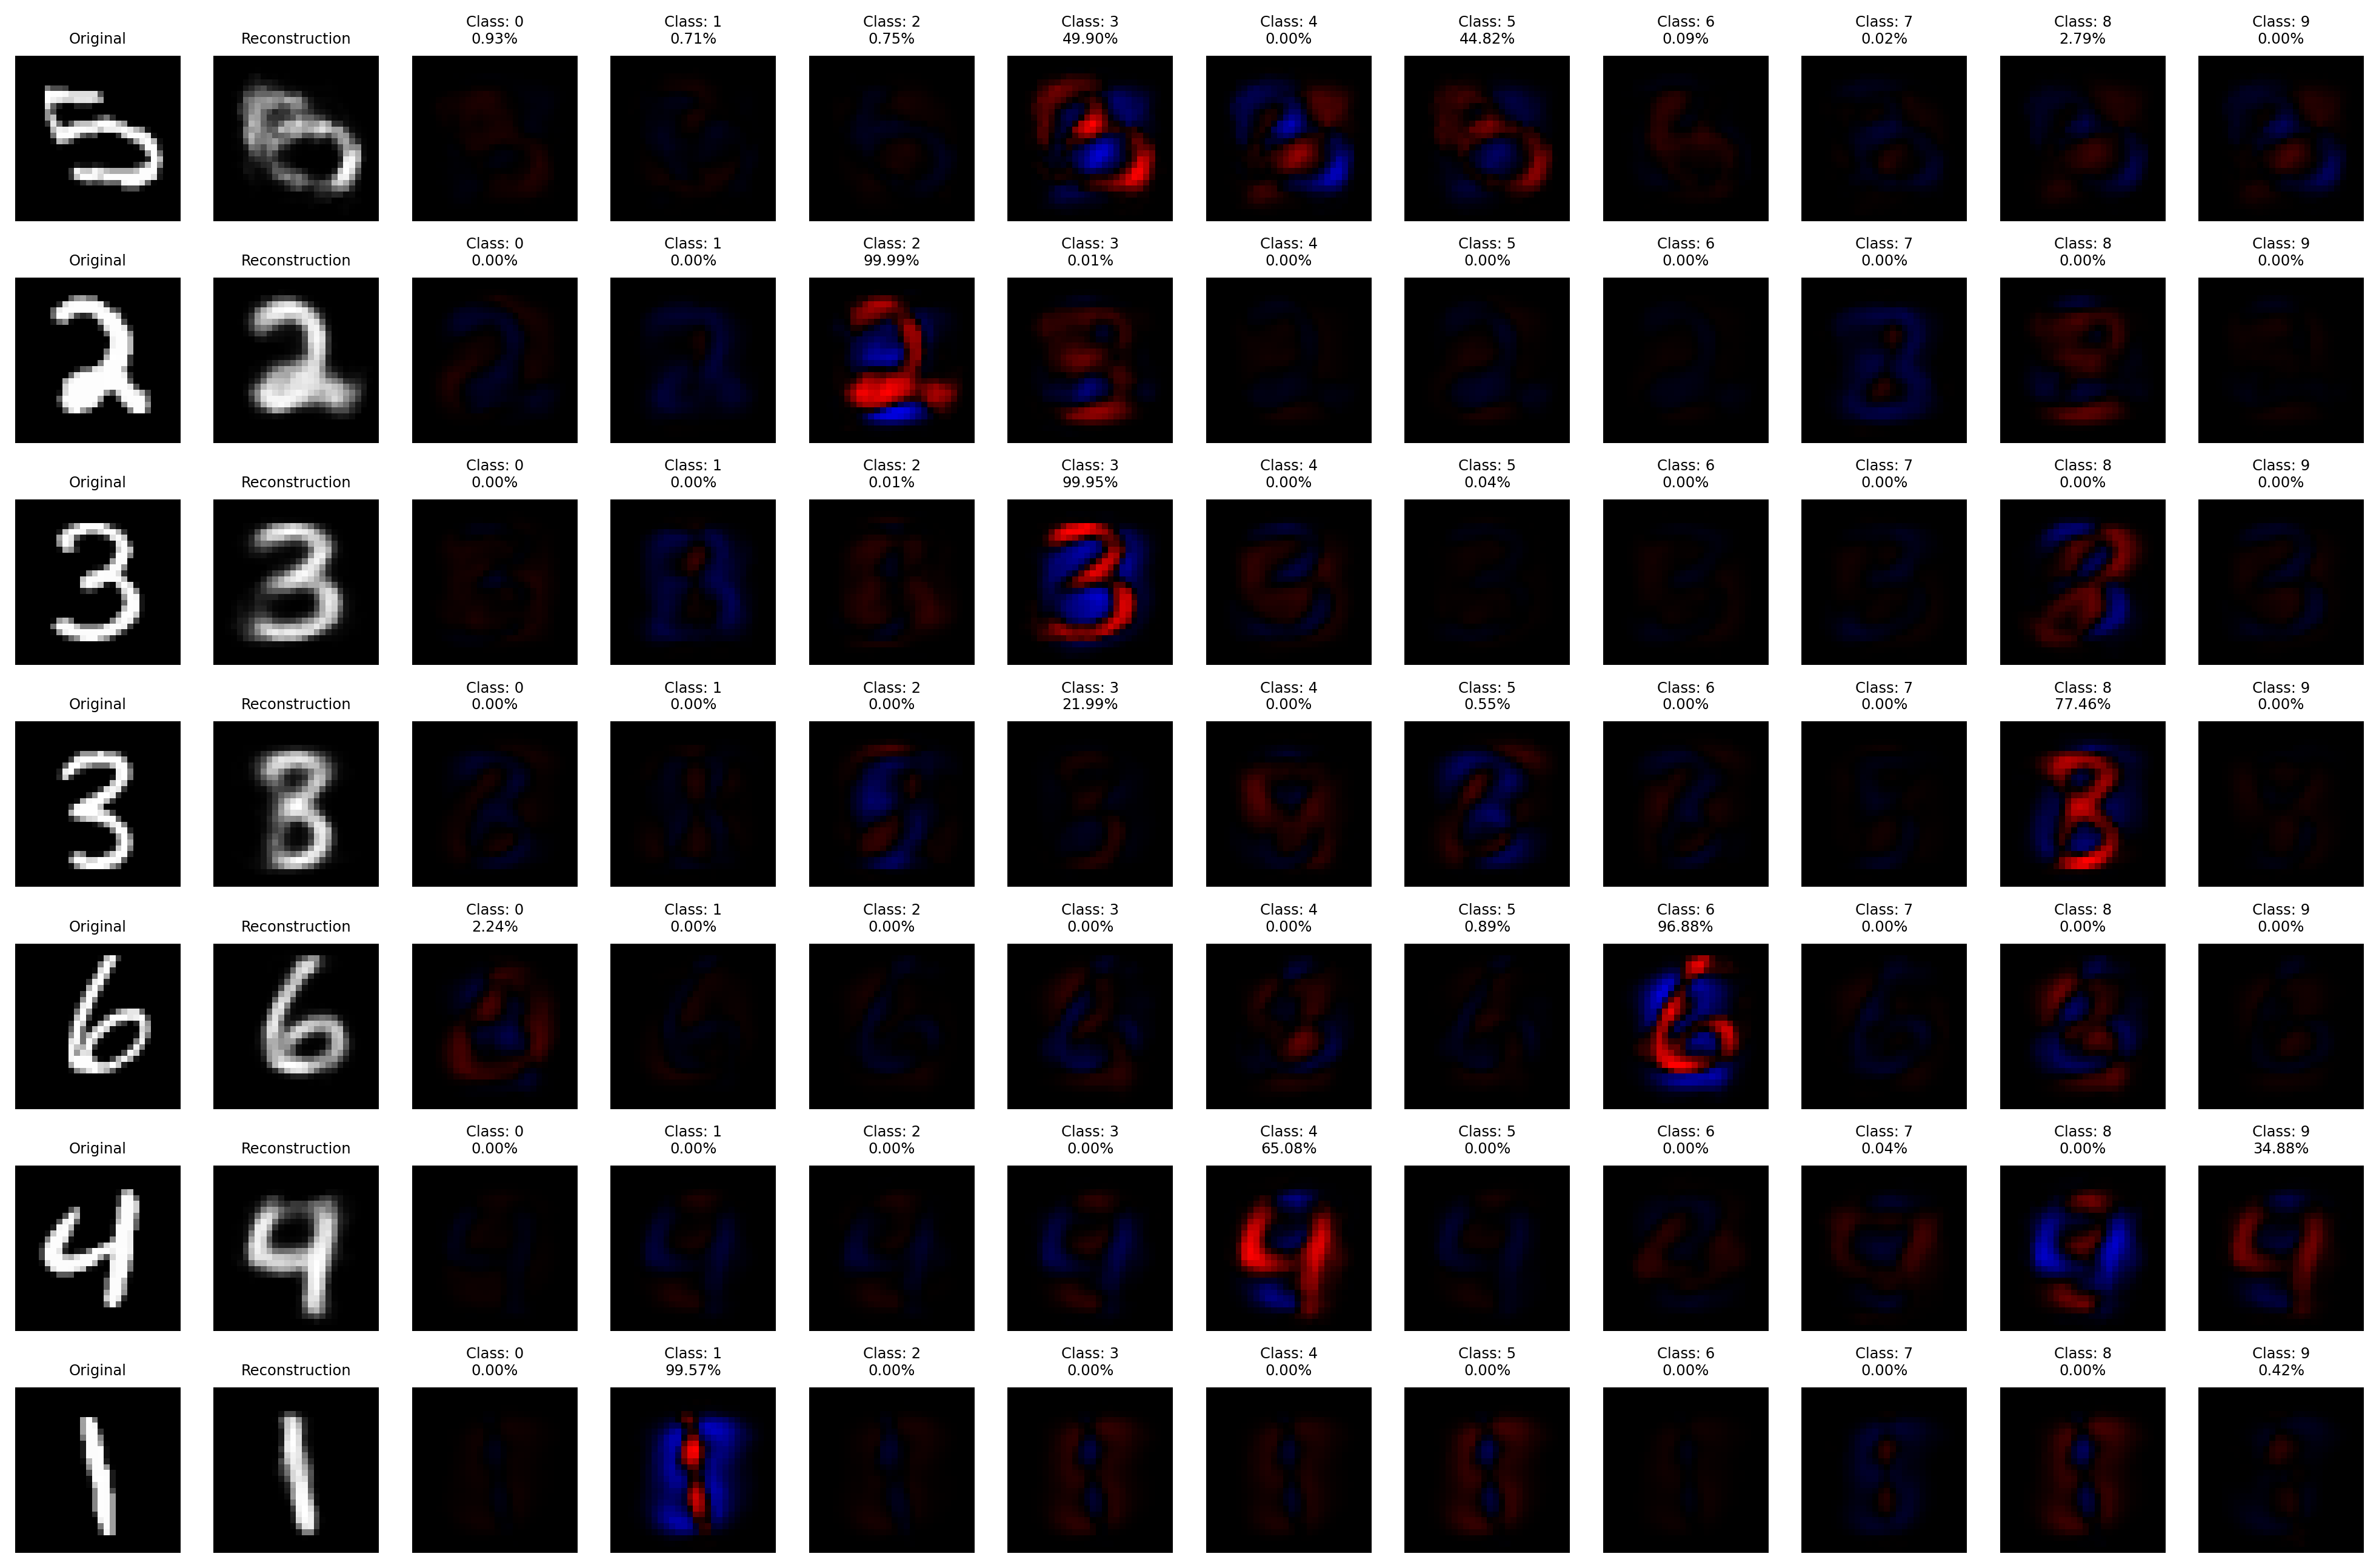

In [7]:
fig = plt.figure(figsize=(20,13), dpi=250) 
rows = 7
columns = 12

for i in range(rows):
    i = i*columns

    idx = random.randrange(0, len(mnist.val_data))

    sample = mnist.val_data[idx].numpy(force=True)
    predict = mnist(sample)
    recon = predict.reconstruction().numpy(force=True)
    digit = predict.digits()[0]
    cls = predict.classification().tolist()

    recon_xai = predict.reconstruction_explanation(PermutationExplainer, verbose=False)[0].values
    cls_xai = predict.classification_explanation(PermutationExplainer, verbose=False)[0].values


    fig.add_subplot(rows,columns,i+1)
    plt.imshow(sample, cmap="gray")
    plt.axis('off')
    plt.title("Original", size=7)
        
    fig.add_subplot(rows,columns,i+2)
    plt.imshow(recon, cmap="gray")
    plt.axis('off')
    plt.title("Reconstruction", size=7)

    shaps = []
        
    for j in range(10):
        shap = np.zeros_like(recon_xai)
        for k in range(latent_dim):
            shap[k] = recon_xai[k] * cls_xai[k,j]

        shap = shap.sum(axis=0)
        shaps.append(shap)

    shaps = np.stack(shaps)
    norm = np.max(np.abs(shaps))
    for j,shap in enumerate(shaps):
        fig.add_subplot(rows,columns,i+j+3)
        im = np.zeros((28,28,3), dtype=np.float32)
        red = np.where(shap > 0, shap/norm, np.zeros_like(shap))
        blue = np.where(shap < 0, -shap/norm, np.zeros_like(shap))
        im[:,:,0] = red
        im[:,:,2] = blue
        plt.imshow(im)
        plt.axis('off')
        plt.title(f"Class: {j}\n{cls[j]*100:.2f}%", size=7)

    digit

In [ ]:
for i in range(latent_dim):
    recon_xai[i] = recon_xai[i] * cls_xai[i]

recon_xai = recon_xai.sum(axis=0)

In [ ]:
im = np.zeros((28,28,3), dtype=np.float32)
norm = np.max(np.abs(recon_xai))
red = np.where(recon_xai > 0, recon_xai/norm, np.zeros_like(recon_xai))
blue = np.where(recon_xai < 0, -recon_xai/norm, np.zeros_like(recon_xai))
im[:,:,0] = red
im[:,:,2] = blue
plt.imshow(im)

In [ ]:
plt.imshow(xai[2])

In [ ]:
images = mnist.val_data
autoencoder = mnist.autoencoder
encoder = autoencoder.encoder
decoder = autoencoder.decoder

plot_images = []
idx = random.randint(0,len(images))
X = images[idx]
Y = mnist(X)
embedding = Y.embedding().numpy(force=True)
reconstruction = Y.reconstruction().numpy(force=True)
digit = Y.digits()

fig = plt.figure(dpi=250, figsize=(10,6)) 
fig.add_subplot(3,5,1)
plot_images.append(X.numpy(force=True))
plt.imshow(X.numpy(force=True), cmap="gray") 
plt.axis('off')
plt.title(f'$x$', size=7)

fig.add_subplot(3,5, 2)
plot_images.append(reconstruction)
plt.imshow(reconstruction, cmap="gray") 
plt.axis('off')
plt.title(f'$\\hat{{x}}^{{-1}}$', size=7)

gradients = Y.gradients(lambda t: t.sum()).numpy(force=True)
grad_norm = np.abs(gradients).max()
blue = np.where(gradients < 0, -gradients/grad_norm, np.zeros_like(gradients))
red = np.where(gradients > 0, gradients/grad_norm, np.zeros_like(gradients))
saliency = np.zeros((28,28,3), dtype=np.float32)
saliency[:,:,2] = blue
saliency[:,:,0] = red

fig.add_subplot(3,5,4)

plot_images.append(saliency)
plt.imshow(saliency, cmap="gray") 
plt.axis('off')
plt.title(f"$saliency(\sum{{\\hat{{x}}^{{-1}}}})$", size=7)

Yi = mnist(images)
embeddings = Yi.embedding().numpy(force=True)
reconstructions = Yi.reconstruction().numpy(force=True)

explainer = shap.PermutationExplainer(lambda t: decoder.flatten()(t).output(), masker=embeddings)
autoencoder_shap_values: shap.Explanation = explainer(embeddings[idx:idx+1], max_evals=21)[0]
autoencoder_shap_values = np.array(autoencoder_shap_values.values).reshape((latent_dim,28,28))

norm = np.abs(autoencoder_shap_values).max()
blue = np.where(autoencoder_shap_values < 0, -autoencoder_shap_values/norm, np.zeros_like(autoencoder_shap_values))
red = np.where(autoencoder_shap_values > 0, autoencoder_shap_values/norm, np.zeros_like(autoencoder_shap_values))

for i in range(5):
    image = np.zeros((28,28,3), dtype=np.float32)
    image[:,:,2] = blue[i]
    image[:,:,0] = red[i]
    fig.add_subplot(3,5,i+10)
    plot_images.append(image)
    plt.imshow(image, cmap="gray")
    plt.axis('off')
    plt.title(f'$shap(l_{i})$', size=7)

fig.add_subplot(3,5,15)

sum_shap = autoencoder_shap_values.sum(axis=0)
norm = np.abs(sum_shap).max()
blue = np.where(sum_shap < 0, -sum_shap/norm, np.zeros_like(sum_shap))
red = np.where(sum_shap > 0, sum_shap/norm, np.zeros_like(sum_shap))
image = np.zeros((28,28,3), dtype=np.float32)
image[:,:,2] = blue
image[:,:,0] = red
plot_images.append(image)
plt.imshow(image)
plt.axis('off')
plt.title(f'$\sum_{{i=0}}^{{5}}{{shap(l_{{i}})}}$', size=7)
plt.show()

In [ ]:
autoencoder_shap_values.shape

In [ ]:
plt.imsave(f"images/mnist_noise0.png", plot_images[0].repeat(8, 0).repeat(8, 1), cmap="gray")
plt.imsave(f"images/mnist_noise1.png", plot_images[1].repeat(8, 0).repeat(8, 1), cmap="gray")
for i,plot_image in enumerate(plot_images[2:], start=2):
    plt.imsave(f"images/mnist_noise{i}.png", plot_image.repeat(8, 0).repeat(8, 1))

In [ ]:
classifier_head = Policy.new(encoder.output_dim,10, hidden_activation="ReLU")
classifier = encoder + classifier_head
classifier

In [ ]:
stats = classifier_head.adam().fit(
    X=encoder(images),
    Y=labels_one_hot.cuda(),
    epochs=5000,
    batch_size=64,
    loss_criterion="CrossEntropyLoss",
    verbose=True,
    info="Classifier test"
)
stats.plot_loss()

In [ ]:
idx = random.randint(0,len(images))
X = images[idx]
Y = classifier(X)
digit = Y.tensor(True).argmax().item()

fig = plt.figure(dpi=250, figsize=(10,5)) 
fig.add_subplot(4,7, 1)
plt.imshow(X, cmap="gray") 
plt.axis('off')
plt.title(f'$x$', size=7)

saliencies = []
for i in range(10):
    fig.add_subplot(4,7,i+2)
    saliencies.append(Y.saliency(lambda t: t[i]))
    plt.imshow(saliencies[-1], cmap="gray")
    plt.axis('off')
    plt.title(f'$\\frac{{dx}}{{d\hat y_{i}}}$', size=7)


for i in range(10):
    gradients = Y.gradients(lambda t: t.sum())
    min,max = gradients.min(), gradients.max()
    if abs(max) > abs(min):
        min = -max
    else:
        max = -min
    blue = torch.where(gradients < 0, gradients/min, torch.zeros_like(gradients))
    red = torch.where(gradients > 0, gradients/max, torch.zeros_like(gradients))
    saliency = torch.zeros((28,28,3), dtype=torch.float32, device="cpu")
    saliency[:,:,0] = blue
    saliency[:,:,1] = red
    fig.add_subplot(4,7,i+12)
    plt.imshow(saliency, cmap="gray")
    plt.axis('off')
    plt.title(f'$\\frac{{dx}}{{d\hat y_{i}}}$', size=7)


data = encoder(images).numpy()
explainer = shap.PermutationExplainer(lambda t: classifier_head(torch.from_numpy(t)).numpy().reshape((-1,10)), masker=data)
classifier_head_shap_values: shap.Explanation = explainer(data[idx:idx+1], max_evals=11)[0]
classifier_head_shap_values = np.array(classifier_head_shap_values.values).reshape((latent_dim,10))

classifier_head_shap_min, classifier_head_shap_max = classifier_head_shap_values.min(), classifier_head_shap_values.max()
if abs(classifier_head_shap_max) > abs(classifier_head_shap_min):
    classifier_head_shap_min = -classifier_head_shap_max
else:
    classifier_head_shap_max = -classifier_head_shap_min


negative = np.where(classifier_head_shap_values < 0, classifier_head_shap_values / classifier_head_shap_min, np.zeros_like(classifier_head_shap_values))
negative = negative / negative.sum(axis=0)

positive = np.where(classifier_head_shap_values > 0, classifier_head_shap_values / classifier_head_shap_max, np.zeros_like(classifier_head_shap_values))
positive = positive / positive.sum(axis=0)

positive.shape

In [ ]:
import shap

explainer = shap.GradientExplainer()
autoencoder_shap_values: shap.Explanation = explainer.shap_values(xi.unsqueeze(0))

explainer()